# Import dependencies

In [1]:
import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
%matplotlib inline

# Prepare data
This test will look at Atlanta as a whole, use date as frequency, aggregate the total crimes count (UCR Literal) based on the date

In [8]:
#Load data
df = pd.read_csv('../raw_data/crime_new-2009-2019_addzip.csv', parse_dates=True)
df.head()

,Report Number,Report Date,Occur Date,Occur Time,Occur time (fixed),Possible Date,Possible Time,Possible time (fixed),Beat,Location,Zipcode,UCR Literal,UCR #,Neighborhood,Latitude,Longitude,Possible Date New,Poss YEAR
0,90010930,"1,01,2009","1,01,2009",1145,11:45,"1,01,2009",1148,11:48:00,411,2841 GREENBRIAR PKWY,30331,LARCENY-NON VEHICLE,630,Greenbriar,33.68845,-84.49328,1/1/2009,2009
1,90011083,"1,01,2009","1,01,2009",1330,13:30,"1,01,2009",1330,13:30:00,511,12 BROAD ST SW,30303,LARCENY-NON VEHICLE,630,Downtown,33.75320,-84.39201,1/1/2009,2009
2,90011208,"1,01,2009","1,01,2009",1500,15:00,"1,01,2009",1520,15:20:00,407,3500 MARTIN L KING JR DR SW,30331,LARCENY-NON VEHICLE,630,Adamsville,33.75735,-84.50282,1/1/2009,2009
3,90011218,"1,01,2009","1,01,2009",1450,14:50,"1,01,2009",1510,15:10:00,210,3393 PEACHTREE RD NE,30326,LARCENY-NON VEHICLE,630,Lenox,33.84676,-84.36212,1/1/2009,2009
4,90011289,"1,01,2009","1,01,2009",1600,16:00,"1,01,2009",1700,17:00:00,411,2841 GREENBRIAR PKWY SW,30331,LARCENY-NON VEHICLE,630,Greenbriar,33.68677,-84.49773,1/1/2009,2009


In [9]:
#Set date as the index, and target variable will be the count of crimes happend on that day.
df_group = df.groupby(['Possible Date New'])
df_bydate = df_group[['UCR Literal']].count()
df_bydate = df_bydate.reset_index()
df_bydate["Possible Date New"] = pd.to_datetime(df_bydate["Possible Date New"])
df_bydate=df_bydate.set_index('Possible Date New')
df_bydate=df_bydate.sort_index()
print(df_bydate)

                   UCR Literal
Possible Date New             
2009-01-01                 116
2009-01-02                 136
2009-01-03                 113
2009-01-04                  97
2009-01-05                 129
...                        ...
2019-12-27                  58
2019-12-28                  61
2019-12-29                  72
2019-12-30                  90
2019-12-31                  45

[4017 rows x 1 columns]


# Plot the data
* Time series plot
* Autocorrelation plot
* Seasonal decompose plot
* ACF and PACF plots

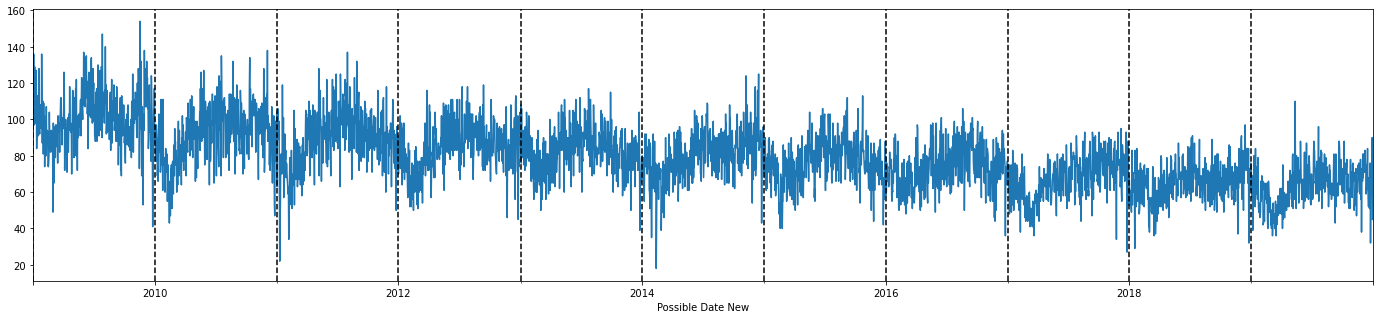

In [10]:
# Time series plot shows downward trend
ax = df_bydate['UCR Literal'].plot(x='Date', y='UCR Count', figsize=(24,5))
xcoords = ['2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

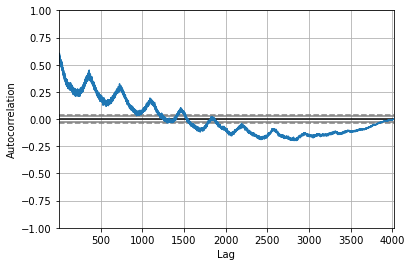

In [11]:
# Autocorrelation plot shows there are some correlations between lags
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_bydate['UCR Literal'])
plt.show()

C:\Users\tyang\Anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tyang\Anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


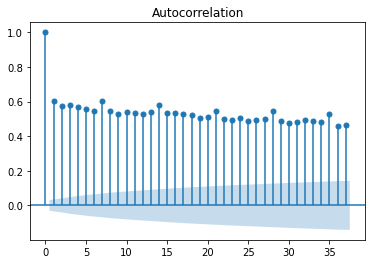

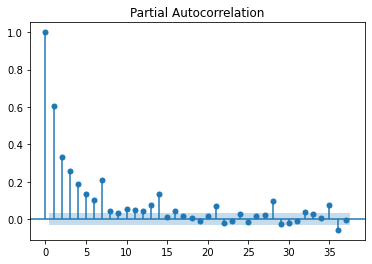

In [12]:
#ACF and PACF plots
data = pd.Series(df_bydate['UCR Literal'])
plot_acf(data).show()
plot_pacf(data).show()

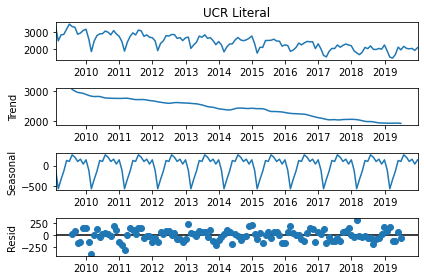

In [13]:
# Seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

y = df_bydate["UCR Literal"].resample('M').sum()
decompose_result_mult = seasonal_decompose(y, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

# Statistical Test
Also perform the statistical test to decide if the data is good for time series model, P-Value is very small, and the ADF score is less than critical values, so it is a good fit for ARIMA model.

In [14]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ", dftest[2])
    print("4. Num of Observations Userd For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical VAlues :")
    for key, val in dftest[4].items():
        print("\t",key, ": ",val)

In [15]:
ad_test(df_bydate['UCR Literal'])

1. ADF :  -3.397984473862071
2. P-Value :  0.01102777294901886
3. Num of Lags :  31
4. Num of Observations Userd For ADF Regression and Critical Values Calculation : 3985
5. Critical VAlues :
	 1% :  -3.431992036963141
	 5% :  -2.862265562109333
	 10% :  -2.567156224565458


# Try auto_arima to find the best parameters

In [16]:
from pmdarima import auto_arima

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
stepwise_fit = auto_arima(df_bydate['UCR Literal'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31309.416, Time=6.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33429.326, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32452.066, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31320.183, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33427.332, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31310.831, Time=5.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31311.163, Time=3.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31309.388, Time=8.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31311.738, Time=4.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=31311.311, Time=9.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=31226.818, Time=14.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=15.33 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=31200.432, Time=17.08 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=31234.934, Time=21.57 sec
 ARIMA(4,1,4)(0,0,0)[

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
print(df_bydate.shape)

(4017, 1)


In [21]:
X = df_bydate['UCR Literal'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions=[]
for t in range(len(test)):
  model = ARIMA(history,order=(4,1,3))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

predicted=73.991885, expected=70.000000
predicted=74.451766, expected=62.000000
predicted=71.580383, expected=88.000000
predicted=74.504127, expected=78.000000
predicted=76.342684, expected=67.000000
predicted=74.191228, expected=75.000000
predicted=73.196949, expected=81.000000
predicted=75.091368, expected=54.000000
predicted=72.176167, expected=63.000000
predicted=69.909512, expected=87.000000
predicted=73.195476, expected=83.000000
predicted=76.013507, expected=75.000000
predicted=75.740953, expected=82.000000
predicted=75.133507, expected=90.000000
predicted=77.358573, expected=78.000000
predicted=78.292254, expected=71.000000
predicted=75.968317, expected=61.000000
predicted=71.958161, expected=76.000000
predicted=74.149416, expected=87.000000
predicted=77.712102, expected=89.000000
predicted=78.363399, expected=81.000000
predicted=77.803263, expected=70.000000
predicted=77.068172, expected=77.000000
predicted=76.517428, expected=70.000000
predicted=74.508919, expected=76.000000


predicted=64.135416, expected=56.000000
predicted=62.214313, expected=72.000000
predicted=65.657736, expected=64.000000
predicted=65.160710, expected=70.000000
predicted=64.544315, expected=64.000000
predicted=65.035317, expected=76.000000
predicted=67.747237, expected=68.000000
predicted=66.330743, expected=81.000000
predicted=68.207100, expected=71.000000
predicted=69.477585, expected=70.000000
predicted=68.774836, expected=55.000000
predicted=64.845673, expected=64.000000
predicted=65.653536, expected=67.000000
predicted=67.252939, expected=63.000000
predicted=65.430996, expected=58.000000
predicted=63.894937, expected=65.000000
predicted=65.568595, expected=87.000000
predicted=69.460042, expected=75.000000
predicted=68.903489, expected=79.000000
predicted=70.541936, expected=68.000000
predicted=70.098329, expected=67.000000
predicted=68.130915, expected=69.000000
predicted=68.156031, expected=71.000000
predicted=69.949503, expected=67.000000
predicted=68.842331, expected=57.000000


predicted=75.114624, expected=91.000000
predicted=76.183469, expected=73.000000
predicted=72.738238, expected=56.000000
predicted=70.903200, expected=62.000000
predicted=70.615911, expected=83.000000
predicted=71.368602, expected=72.000000
predicted=71.667960, expected=50.000000
predicted=69.771397, expected=79.000000
predicted=70.745337, expected=65.000000
predicted=68.241366, expected=75.000000
predicted=71.514193, expected=84.000000
predicted=74.696287, expected=97.000000
predicted=75.479224, expected=76.000000
predicted=74.740572, expected=76.000000
predicted=76.655150, expected=72.000000
predicted=74.165935, expected=77.000000
predicted=72.728258, expected=84.000000
predicted=77.081493, expected=74.000000
predicted=77.092650, expected=84.000000
predicted=75.332143, expected=65.000000
predicted=73.530212, expected=66.000000
predicted=74.995108, expected=84.000000
predicted=75.571520, expected=32.000000
predicted=65.983738, expected=63.000000
predicted=68.715140, expected=73.000000


predicted=68.607275, expected=70.000000
predicted=69.985534, expected=69.000000
predicted=70.467574, expected=54.000000
predicted=65.479660, expected=53.000000
predicted=63.729007, expected=54.000000
predicted=64.833884, expected=70.000000
predicted=65.567606, expected=56.000000
predicted=62.624904, expected=59.000000
predicted=63.783233, expected=56.000000
predicted=63.570910, expected=59.000000
predicted=61.103101, expected=57.000000
predicted=60.896503, expected=78.000000
predicted=66.140713, expected=88.000000
predicted=68.716487, expected=83.000000
predicted=68.727184, expected=83.000000
predicted=71.750033, expected=75.000000
predicted=71.938619, expected=65.000000
predicted=68.043052, expected=66.000000
predicted=67.844696, expected=59.000000
predicted=68.306657, expected=73.000000
predicted=68.437853, expected=73.000000
predicted=68.062439, expected=77.000000
predicted=71.064654, expected=62.000000
predicted=69.765606, expected=73.000000
predicted=68.251048, expected=59.000000


# Model Evaluation

In [22]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4015
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -15562.366
Method:                       css-mle   S.D. of innovations             11.663
Date:                Thu, 26 Aug 2021   AIC                          31142.732
Time:                        14:17:28   BIC                          31199.412
Sample:                             1   HQIC                         31162.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0109      0.020     -0.547      0.584      -0.050       0.028
ar.L1.D.y     -0.3570      0.016    -21.893      0.000      -0.389      -0.325
ar.L2.D.y     -0.9167      0.013    -72.187      0.0

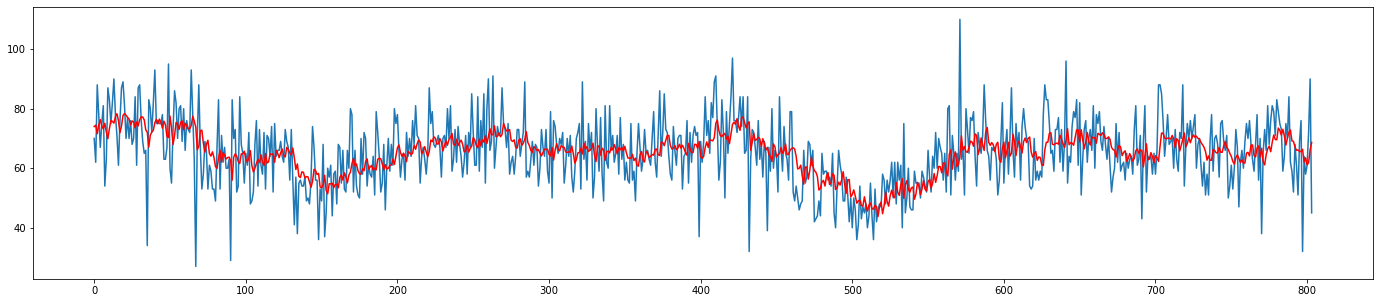

In [23]:
figure(figsize=(24, 5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [24]:
from sklearn.metrics import r2_score
r2_score(test,predictions)

0.20854503245410616

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)
print(test.mean())


10.18205901728978
65.23756218905473


#How to use model to predict - research

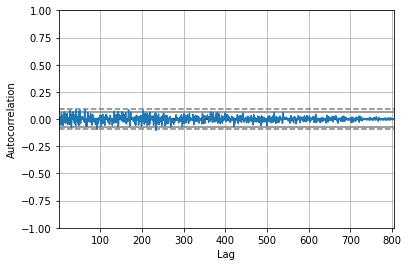

In [26]:
from pandas.plotting import autocorrelation_plot
residuals = [test[i]-predictions[i] for i in range(len(predictions))]
autocorrelation_plot(residuals)
plt.show()

# Forecast

In [28]:
# use the full dataset
model1 = ARIMA(df_bydate['UCR Literal'],order=(4,1,3))
model_fit1 = model1.fit()

            prediction
2020-01-01   61.927138
2020-01-02   63.991862
2020-01-03   64.996667
2020-01-04   62.547245
2020-01-05   63.429453
...                ...
2021-12-27   56.996473
2021-12-28   55.699008
2021-12-29   54.207282
2021-12-30   56.139192
2021-12-31   56.743551

[731 rows x 1 columns]


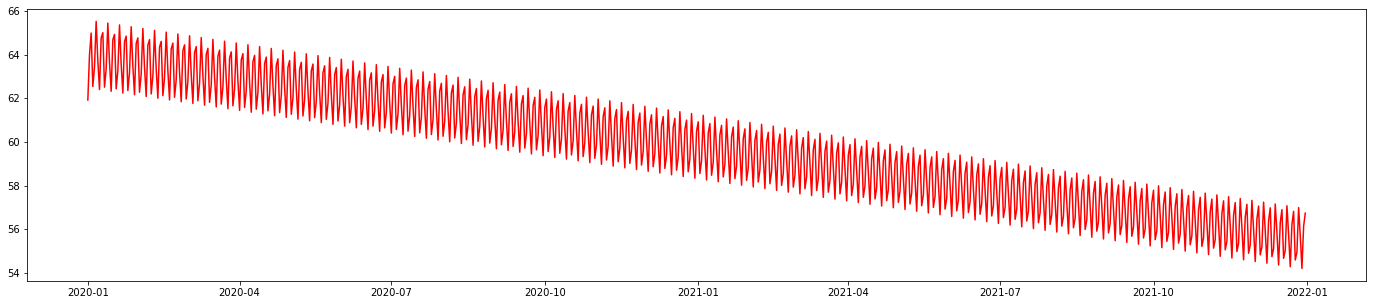

In [29]:
forecast = model_fit1.forecast(steps=731)
pred = forecast[0]
index_future_dates=pd.date_range(start='2020-01-01', end='2021-12-31')
pred =pd.DataFrame(pred,columns = ['prediction'])
pred.index = index_future_dates
figure(figsize=(24, 5))
plt.plot(pred['prediction'], color='red')
print(pred)